# Modelo lineal generalizado

Para hacer un GLM, usaremos también las dos librerías de siempre, pero debemos tener en cuenta de que en [`sklearn`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) existe una variedad menor de distribuciones que podemos poner y que además no nos ofrece la posibilidad de ver tanto los estadísticos habituales de ajuste como algunos test que se le suelen aplicar.

## Importaciones

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.formula.api import glm
from statsmodels.genmod.families import Poisson
from sklearn.linear_model import PoissonRegressor
import seaborn as sns
import matplotlib.pyplot as plt

## Generación del conjunto de datos

Supongamos que queremos saber el número de becas de un deportista de alto nivel que juega al Beisbol dadas la división en la que juegan (A, B o C) y la nota de entrada a la universidad. 

El objetivo es predecir el número de becas que le ha tocado a un deportista. Esta variable, sigue una distribución de tipo Poisson. Por lo tanto, el modelo que ajustaremos será el siguiente:

$$Y \sim \text{Po}(\lambda) \\ \log(\lambda) = \beta_0 + \beta_1 \text{examen} + \beta_2\text{division}_B + \beta_3\text{division}_C + \varepsilon$$

In [2]:
data = pd.read_csv("./datos/baseball.csv")
data.ofertas = data.ofertas.astype(str)
del data['Unnamed: 0']

In [3]:
data

ofertas division     examen
0        0        A  74.492158
1        0        B  73.957962
2        0        B  75.700027
3        0        C  62.342341
4        0        C  74.703732
..     ...      ...        ...
95       3        A  88.132043
96       3        B  78.348220
97       4        B  84.070417
98       4        A  85.461730
99       4        A  94.810592

[100 rows x 3 columns]

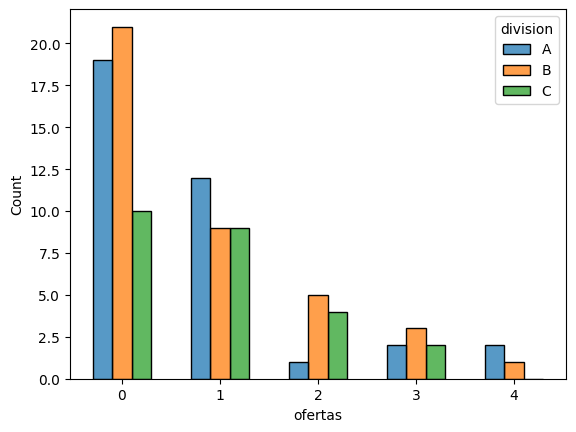

In [4]:
sns.histplot(x = 'ofertas', hue = 'division', data = data, multiple="dodge", shrink= 0.6)
plt.show()
data.ofertas = data.ofertas.astype(int)

## Regresión Poisson

In [5]:
model = glm("ofertas ~ division + examen", data = data, family = Poisson())
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                ofertas   No. Observations:                  100
Model:                            GLM   Df Residuals:                       96
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -105.43
Date:                Sat, 20 Jan 2024   Deviance:                       93.976
Time:                        15:57:58   Pearson chi2:                     90.5
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3566
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.7706      1.077     -6.287      0.000      -8.881      -4.660
division[T.B]     0.4287      0.268      1.602      0.109      -0.096       0.953
division[T.C]     0.2293      0.281      0.815      0.415      -0.322       0.781
examen            0.0806      0.013      6.410      0.000       0.056       0.105
=================================================================================
"""

In [6]:
data_copia = data.copy(deep=True)
data_copia = pd.get_dummies(data_copia)
del data_copia['division_A']

X = data_copia.loc[:,data_copia.columns != "ofertas"]
y = data_copia.loc[:,data_copia.columns == "ofertas"]
po_reg = PoissonRegressor(alpha = 0)
po_reg.fit(X, np.ravel(y))

pd.DataFrame({'Coeficientes':po_reg.feature_names_in_, 'Valores':po_reg.coef_})

Coeficientes   Valores
0       examen  0.080596
1   division_B  0.428748
2   division_C  0.229342

Como anteriormente, el parámetro `alpha` de `PoissonRegressor` es una medida de penalización que vamos a eliminar en este caso para comprobar que los dos modelos están proporcionando los mismos resultados.

Dado que ya no estamos en una situación de normalidad, los test han cambiado. `Pearson chi2` es un estadístico que se usa para evaluar la discrepancia entre la distribución observada y la teórica, indicando en qué medida son diferentes. Cuanto más alto sea, peor es el ajuste. 

Aquí, no existe el $R^2$ porque estamos en un entorno de clases, por lo que se han propuesto otras medidas que pueden hacer el papel de este para este tipo de variables respuesta, que son los  [`Pseudo R-squ. (CS)`](https://en.wikipedia.org/wiki/Pseudo-R-squared).

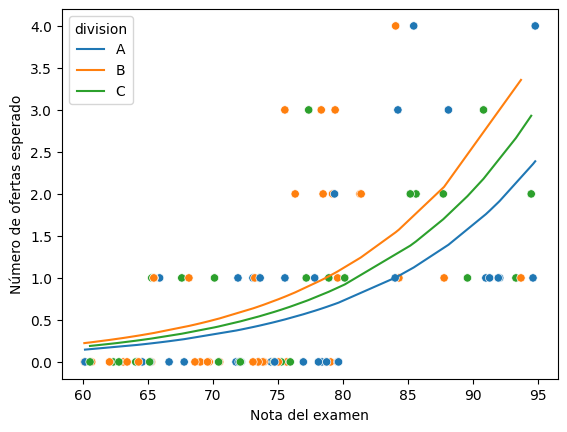

In [7]:
data_con_preds = data.copy(deep=True)
data_con_preds['predicciones'] = results.predict(data)

sns.lineplot(x ='examen', y = 'predicciones', hue = 'division', data = data_con_preds)
sns.scatterplot(x = 'examen', y = 'ofertas', hue = 'division', data = data_con_preds, legend= False)
plt.xlabel("Nota del examen")
plt.ylabel('Número de ofertas esperado')
plt.show()